**Amazon SageMaker Multi-Model Endpoints using XGBoost**

**Multi-model endpoints**

Multi-model endpoints provide a scalable and cost-effective solution to deploying large numbers of models. They use the same fleet of resources and a shared serving container to host all of your models. This reduces hosting costs by improving endpoint utilization compared with using single-model endpoints. It also reduces deployment overhead because Amazon SageMaker AI manages loading models in memory and scaling them based on the traffic patterns to your endpoint.

The following diagram shows how multi-model endpoints work compared to single-model endpoints.
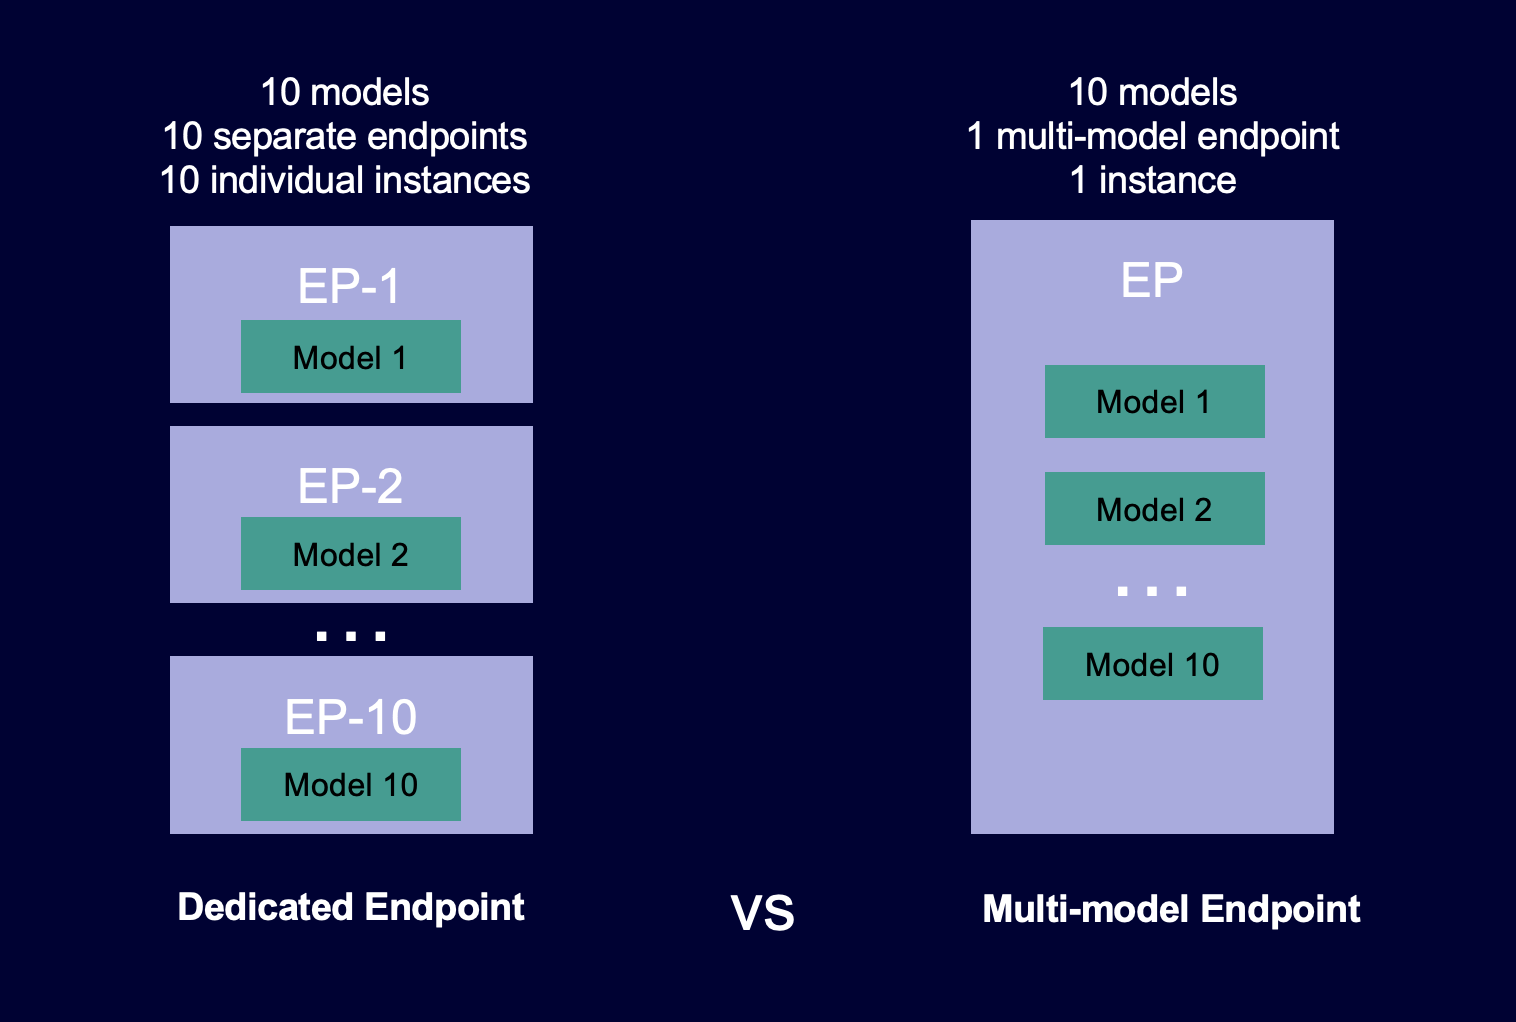

Multi-model endpoints are ideal for hosting a large number of models that use the same ML framework on a shared serving container. If you have a mix of frequently and infrequently accessed models, a multi-model endpoint can efficiently serve this traffic with fewer resources and higher cost savings. Your application should be tolerant of occasional cold start-related latency penalties that occur when invoking infrequently used models.

Multi-model endpoints support hosting both CPU and GPU backed models. By using GPU backed models, you can lower your model deployment costs through increased usage of the endpoint and its underlying accelerated compute instances.

Multi-model endpoints also enable time-sharing of memory resources across your models. This works best when the models are fairly similar in size and invocation latency. When this is the case, multi-model endpoints can effectively use instances across all models. If you have models that have significantly higher transactions per second (TPS) or latency requirements, we recommend hosting them on dedicated endpoints.



With Amazon SageMaker multi-model endpoints, customers can create an endpoint that seamlessly hosts up to thousands of models. These endpoints are well suited to use cases where any one of a large number of models, which can be served from a common inference container to save inference costs, needs to be invokable on-demand and where it is acceptable for infrequently invoked models to incur some additional latency. For applications which require consistently low inference latency, an endpoint deploying a single model is still the best choice.

At a high level, Amazon SageMaker manages the loading and unloading of models for a multi-model endpoint, as they are needed. When an invocation request is made for a particular model, Amazon SageMaker routes the request to an instance assigned to that model, downloads the model artifacts from S3 onto that instance, and initiates loading of the model into the memory of the container. As soon as the loading is complete, Amazon SageMaker performs the requested invocation and returns the result. If the model is already loaded in memory on the selected instance, the downloading and loading steps are skipped and the invocation is performed immediately.

To demonstrate how multi-model endpoints are created and used, this notebook provides an example using a set of XGBoost models that each predict housing prices for a single location. This domain is used as a simple example to easily experiment with multi-model endpoints.

The Amazon SageMaker multi-model endpoint capability is designed to work across with Mxnet, PyTorch and Scikit-Learn machine learning frameworks (TensorFlow coming soon), SageMaker XGBoost, KNN, and Linear Learner algorithms.

In addition, Amazon SageMaker multi-model endpoints are also designed to work with cases where you bring your own container that integrates with the multi-model server library. An example of this can be found here and documentation here.

In [1]:
!pip install -Uq sagemaker


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
!pip install scikit-learn

  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.7 MB ? eta -:--:--
   ------- -------------------------------- 1.6/8.7 MB 3.9 MB/s eta 0:00:02
   ------------- -------------------------- 2.9/8.7 MB 4.8 MB/s eta 0:00:02
   ------------------------- -------------- 5.5/8.7 MB 6.9 MB/s eta 0:00:01
   --------------------------- ------------ 6.0/8.7 MB 7.3 MB/s eta 0:00:01
   --------------------------- ------------ 6.0/8.7 MB 7.3 MB/s eta 0:00:01
   --------------------------- ------------ 6.0/8.7 MB 7.3 MB/s eta 0:00:01
   --------------------------- ------------ 6.0/8.7 MB 7.3 MB/s eta 0:00:01
   --------------------------- ------------ 6.0/8.7 MB 7.3 MB/s eta 0:00:01
   --------------------------- ------------ 6.0/8.7 M


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
!pip install python-dotenv


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sagemaker

print(sagemaker.__version__)

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\juliu\AppData\Local\sagemaker\sagemaker\config.yaml
2.249.0



**1. Generate synthetic data**

The code below contains helper functions to generate synthetic data in the form of a 1x7 numpy array representing the features of a house.

The first entry in the array is the randomly generated price of a house. The remaining entries are the features (i.e. number of bedroom, square feet, number of bathrooms, etc.).

These functions will be used to generate synthetic data for training, validation, and testing. It will also allow us to submit synthetic payloads for inference to test our multi-model endpoint

In [41]:
import numpy as np
import pandas as pd
import time

NUM_HOUSES_PER_LOCATION = 1000
LOCATIONS = [
    "NewYork_NY",
    "LosAngeles_CA",
    "Chicago_IL",
    "Houston_TX",
    "Dallas_TX",
    "Phoenix_AZ",
    "Philadelphia_PA",
    "SanAntonio_TX",
    "SanDiego_CA",
    "SanFrancisco_CA",
]
PARALLEL_TRAINING_JOBS = 2
MAX_YEAR = 2019

Model parallelism is a distributed training method in which the deep learning model is partitioned across multiple devices, within or across instances. This introduction page provides a high-level overview about model parallelism, a description of how it can help overcome issues that arise when training DL models that are typically very large in size, and examples of what the SageMaker model parallel library offers to help manage model parallel strategies as well as memory consumption.

Increasing the size of deep learning models (layers and parameters) yields better accuracy for complex tasks such as computer vision and natural language processing. However, there is a limit to the maximum model size you can fit in the memory of a single GPU. When training DL models, GPU memory limitations can be bottlenecks in the following ways:

They limit the size of the model you can train, since the memory footprint of a model scales proportionally to the number of parameters.

They limit the per-GPU batch size during training, driving down GPU utilization and training efficiency.

To overcome the limitations associated with training a model on a single GPU, SageMaker provides the model parallel library to help distribute and train DL models efficiently on multiple compute nodes. Furthermore, with the library, you can achieve most optimized distributed training using EFA-supported devices, which enhance the performance of inter-node communication with low latency, high throughput, and OS bypass.

In [5]:
def gen_price(house):
    _base_price = int(house["SQUARE_FEET"] * 150)
    _price = int(
        _base_price
        + (10000 * house["NUM_BEDROOMS"])
        + (15000 * house["NUM_BATHROOMS"])
        + (15000 * house["LOT_ACRES"])
        + (15000 * house["GARAGE_SPACES"])
        - (5000 * (MAX_YEAR - house["YEAR_BUILT"]))
    )
    return _price

In [6]:
def gen_random_house():
    _house = {
        "SQUARE_FEET": int(np.random.normal(3000, 750)),
        "NUM_BEDROOMS": np.random.randint(2, 7),
        "NUM_BATHROOMS": np.random.randint(2, 7) / 2,
        "LOT_ACRES": round(np.random.normal(1.0, 0.25), 2),
        "GARAGE_SPACES": np.random.randint(0, 4),
        "YEAR_BUILT": min(MAX_YEAR, int(np.random.normal(1995, 10))),
    }
    _price = gen_price(_house)
    return [
        _price,
        _house["YEAR_BUILT"],
        _house["SQUARE_FEET"],
        _house["NUM_BEDROOMS"],
        _house["NUM_BATHROOMS"],
        _house["LOT_ACRES"],
        _house["GARAGE_SPACES"],
    ]

In [7]:
def gen_houses(num_houses):
    _house_list = []
    for i in range(num_houses):
        _house_list.append(gen_random_house())
    _df = pd.DataFrame(
        _house_list,
        columns=[
            "PRICE",
            "YEAR_BUILT",
            "SQUARE_FEET",
            "NUM_BEDROOMS",
            "NUM_BATHROOMS",
            "LOT_ACRES",
            "GARAGE_SPACES",
        ],
    )
    return _df

**2. Train multiple house value prediction models**

In the follow section, we are setting up the code to train a house price prediction model for each of 4 different cities.

As such, we will launch multiple training jobs asynchronously, using the XGBoost algorithm.

In this notebook, we will be using the AWS Managed XGBoost Image for both training and inference - this image provides native support for launching multi-model endpoints.

In [14]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import image_uris
import boto3
from time import gmtime, strftime
from sklearn.model_selection import train_test_split


In [55]:
import os
from dotenv import load_dotenv

load_dotenv()

s3 = boto3.resource("s3")
sagemaker_session = sagemaker.Session()

# === Potential issue in assigning role === #
role = os.getenv("AWS_SAGEMAKER_ROLE")



In [56]:
BUCKET = sagemaker_session.default_bucket()
#BUCKET

In [49]:
# This is references the AWS managed XGBoost container
XGBOOST_IMAGE = image_uris.retrieve(
    region=boto3.Session().region_name, framework="xgboost", version="1.5-1"
)
DATA_PREFIX = "XGBOOST_BOSTON_HOUSING"
MULTI_MODEL_ARTIFACTS = "multi_model_artifacts"

TRAIN_INSTANCE_TYPE = "ml.t3.medium"
ENDPOINT_INSTANCE_TYPE = "ml.t3.medium"

ENDPOINT_NAME = f'mme-xgboost-housing-{strftime("%Y-%m-%d-%H-%M-%S", gmtime())}'

MODEL_NAME = ENDPOINT_NAME


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


**3. Split a given dataset into train, validation, and test**

The code below will generate 3 sets of data. 1 set to train, 1 set for validation and 1 for testing.

In [50]:
SEED = 7
SPLIT_RATIOS = [0.6, 0.3, 0.1]


def split_data(df):
    # split data into train and test sets
    seed = SEED
    val_size = SPLIT_RATIOS[1]
    test_size = SPLIT_RATIOS[2]

    num_samples = df.shape[0]
    X1 = df.values[:num_samples, 1:]  # keep only the features, skip the target, all rows
    Y1 = df.values[:num_samples, :1]  # keep only the target, all rows

    # Use split ratios to divide up into train/val/test
    X_train, X_val, y_train, y_val = train_test_split(
        X1, Y1, test_size=(test_size + val_size), random_state=seed
    )
    # Of the remaining non-training samples, give proper ratio to validation and to test
    X_test, X_test, y_test, y_test = train_test_split(
        X_val, y_val, test_size=(test_size / (test_size + val_size)), random_state=seed
    )
    # reassemble the datasets with target in first column and features after that
    _train = np.concatenate([y_train, X_train], axis=1)
    _val = np.concatenate([y_val, X_val], axis=1)
    _test = np.concatenate([y_test, X_test], axis=1)

    return _train, _val, _test

**4.Launch a single training job for a given housing location**

There is nothing specific to multi-model endpoints in terms of the models it will host. They are trained in the same way as all other SageMaker models. Here we are using the XGBoost estimator and not waiting for the job to complete.

In [51]:
def launch_training_job(location):
    # clear out old versions of the data
    s3_bucket = s3.Bucket(BUCKET)
    full_input_prefix = f"{DATA_PREFIX}/model_prep/{location}"
    s3_bucket.objects.filter(Prefix=full_input_prefix + "/").delete()

    # upload the entire set of data for all three channels
    local_folder = f"data/{location}"
    inputs = sagemaker_session.upload_data(path=local_folder, key_prefix=full_input_prefix)
    print(f"Training data uploaded: {inputs}")

    _job = "xgb-{}".format(location.replace("_", "-"))
    full_output_prefix = f"{DATA_PREFIX}/model_artifacts/{location}"
    s3_output_path = f"s3://{BUCKET}/{full_output_prefix}"

    xgb = sagemaker.estimator.Estimator(
        XGBOOST_IMAGE,
        role,
        instance_count=1,
        instance_type=TRAIN_INSTANCE_TYPE,
        output_path=s3_output_path,
        base_job_name=_job,
        sagemaker_session=sagemaker_session,
    )

    xgb.set_hyperparameters(
        max_depth=5,
        eta=0.2,
        gamma=4,
        min_child_weight=6,
        subsample=0.8,
        verbosity=0,
        early_stopping_rounds=5,
        objective="reg:squarederror",
        num_round=25,
    )

    DISTRIBUTION_MODE = "FullyReplicated"

    train_input = sagemaker.inputs.TrainingInput(
        s3_data=inputs + "/train", distribution=DISTRIBUTION_MODE, content_type="csv"
    )

    val_input = sagemaker.inputs.TrainingInput(
        s3_data=inputs + "/val", distribution=DISTRIBUTION_MODE, content_type="csv"
    )

    remote_inputs = {"train": train_input, "validation": val_input}

    xgb.fit(remote_inputs, wait=False)

    # Return the estimator object
    return xgb

Kick off a model training job for each housing location

In [52]:
def save_data_locally(location, train, val, test):
    os.makedirs(f"data/{location}/train")
    np.savetxt(f"data/{location}/train/{location}_train.csv", train, delimiter=",", fmt="%.2f")

    os.makedirs(f"data/{location}/val")
    np.savetxt(f"data/{location}/val/{location}_val.csv", val, delimiter=",", fmt="%.2f")

    os.makedirs(f"data/{location}/test")
    np.savetxt(f"data/{location}/test/{location}_test.csv", test, delimiter=",", fmt="%.2f")

In [54]:
import shutil
import os

estimators = []

shutil.rmtree("data", ignore_errors=True)

for loc in LOCATIONS[:PARALLEL_TRAINING_JOBS]:
    _houses = gen_houses(NUM_HOUSES_PER_LOCATION)
    _train, _val, _test = split_data(_houses)
    save_data_locally(loc, _train, _val, _test)
    estimator = launch_training_job(loc)
    estimators.append(estimator)

print()
print(
    f"{len(estimators)} training jobs launched: {[x.latest_training_job.job_name for x in estimators]}"
)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: xgb-NewYork-NY-2025-08-04-13-40-40-409


Training data uploaded: s3://sagemaker-eu-north-1-904233099533/XGBOOST_BOSTON_HOUSING/model_prep/NewYork_NY


ERROR:sagemaker:Please check the troubleshooting guide for common errors: https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-python-sdk-troubleshooting.html#sagemaker-python-sdk-troubleshooting-create-training-job


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:12                                                                                   │
│                                                                                                  │
│    9 │   _houses = gen_houses(NUM_HOUSES_PER_LOCATION)                                           │
│   10 │   _train, _val, _test = split_data(_houses)                                               │
│   11 │   save_data_locally(loc, _train, _val, _test)                                             │
│ ❱ 12 │   estimator = launch_training_job(loc)                                                    │
│   13 │   estimators.append(estimator)                                                            │
│   14                                                                                             │
│   15 print()                                                                                     │
│                                                                                                  │
│ in launch_training_job:50                                                                        │
│                                                                                                  │
│   47 │                                                                                           │
│   48 │   remote_inputs = {"train": train_input, "validation": val_input}                         │
│   49 │                                                                                           │
│ ❱ 50 │   xgb.fit(remote_inputs, wait=False)                                                      │
│   51 │                                                                                           │
│   52 │   # Return the estimator object                                                           │
│   53 │   return xgb                                                                              │
│                                                                                                  │
│ c:\Users\juliu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sagemaker\telemetry\tel │
│ emetry_logging.py:168 in wrapper                                                                 │
│                                                                                                  │
│   165 │   │   │   │   │   caught_ex = e                                                          │
│   166 │   │   │   │   finally:                                                                   │
│   167 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 168 │   │   │   │   │   │   raise caught_ex                                                    │
│   169 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   170 │   │   │   else:                                                                          │
│   171 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ c:\Users\juliu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sagemaker\telemetry\tel │
│ emetry_logging.py:139 in wrapper                                                                 │
│                                                                                                  │
│   136 │   │   │   │   start_timer = perf_counter()                                               │
│   137 │   │   │   │   try:                                                                       │
│   138 │   │   │   │   │   # Call the original function                                           │
│ ❱ 139 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   140 │   │   │   │   │   stop_timer = perf_counter()      